# Find Teleconnections (precursor regions) via correlation maps 

In [1]:
import os
from RGCPD import RGCPD
from RGCPD import BivariateMI
from RGCPD import class_BivariateMI, functions_pp, core_pp
from IPython.display import Image
import numpy as np
import pandas as pd

/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc.py:27: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/independence_tests/gpdc_torch.py:33: UserWarning: No module named 'dcor'
  warnings.warn(str(e))
/home/svijverber/.conda/envs/RGCPD/lib/python3.8/site-packages/tigramite/plotting.py:26: UserWarning: No module named 'networkx'
  warnings.warn(str(e))


In [2]:
path_obs_data = '/data/volume_2/observational/'

target = core_pp.import_ds_lazy(os.path.join(path_obs_data, 'chrips_1981-2021_target_new.nc'))

df_target = target['spatial_mean_raw'].to_dataframe()
# shift target two weeks forward to fool the pipeline, thereby making a 14 day lead-time when lag=1
dates_orig = core_pp.remove_leapdays(df_target.index) # make sure we ignore leap-days
n_days_shift = 14
dates_2week = dates_orig + pd.Timedelta(f'{n_days_shift}d') # shift timeseries
dates_2week = [d for d in dates_2week if d in dates_orig] # remove unavailable 2 weeks at right edge of dates

missing_dates = dates_orig[:n_days_shift] # fill in zeros at beginning missing dates due to shifting

df_target_shifted = df_target.loc[pd.to_datetime(dates_2week)]
df_empty = pd.DataFrame(np.zeros(n_days_shift), index=missing_dates, columns=df_target.columns)
df_target_shifted = pd.concat([df_empty, df_target])
df_missing_lp = [d for d in df_target.index if d not in df_target_shifted.index]
assert len(df_missing_lp) == 0, ('dates are missing')


# define input by filling list_of_name_path: 
# format list_of_name_path = [('TVname', 'TVpath'), ('prec_name', 'prec_path')]
list_of_name_path = [('', df_target),
                    ('sst', os.path.join(path_obs_data, 'raw', 'era5_sst_1959-2021_1_12_daily_2.0deg.nc')),
                    ('sm', os.path.join(path_obs_data, 'raw', 'gleam_SMroot_1980-2021_daily_1.0deg_65S-65N_fix.nc'))]

# define analysis:
list_for_MI = [BivariateMI(name='sst', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False),
              BivariateMI(name='sm', 
                           alpha=.01, FDR_control=True, lags=np.array([1]), 
                           distance_eps=700, min_area_in_degrees2=5, lag_as_gap=False)]


# Time-handling subseasonal mode
4-week (28 day) mean periods that fall within OND period

In [3]:
rg = RGCPD(list_of_name_path=list_of_name_path,
           list_for_MI=list_for_MI,
           tfreq=28, # <- subseasonal forecasting mode, all data will be aggregated to 10-day means
           start_end_TVdate=('10-01', '12-31'), # <- defining target period 
           start_end_year=(1981, 2021),
           path_outmain='./output_lorentz')

In [4]:
rg.pp_precursors(detrend=True, anomaly=True, selbox=None)

Loaded pre-processed data of sst

Loaded pre-processed data of sm



Option for pp_precursors to vary pre-processing of datasets by given a list as an argument:
An example: detrend=[True, {'sm1':False, 'sm2':False}]. This input means that default argument is True, except the variables sm1 and sm2 got a different argument. The precursor names sm1 and sm2 should refer to the names given in list_of_name_path.

### Post-processing Target Variable

Start linear detrending ...
Done
Visual test on 0th observationusing absolute anomalies w.r.t. climatology of smoothed concurrent day accross years
original tfreq of imported response variable is converted to desired 28 (daily) means


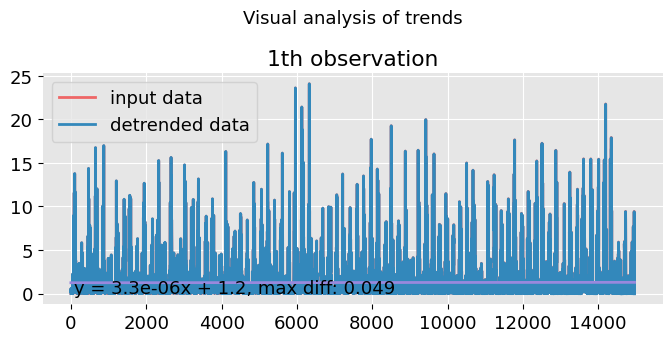

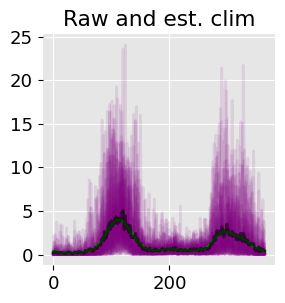

In [5]:
rg.pp_TV(detrend=True, anomaly=True)

In [6]:
rg.df_fullts

,spatial_mean_raw
1981-01-16,-0.112610
1981-02-13,0.034485
1981-03-13,1.793769
1981-04-10,3.000695
1981-05-08,0.295721
...,...
2021-08-28,-0.100138
2021-09-25,-0.040325
2021-10-23,-1.570205
2021-11-20,-0.787996


In [8]:
rg.traintest(method='leave_10', gap_prior=1, gap_after=1, seed=2)
# rg._get_testyrs()[0] # see test years

In [9]:
rg.calc_corr_maps() 


sst - calculating correlation maps
Progress traintest set 100%, trainsize=(90dp, 73%)


SMroot - calculating correlation maps
Progress traintest set 100%, trainsize=(90dp, 73%)



Plotting sst
Plotting Corr maps sst, split 0, lag 1
Plotting sm
Plotting Corr maps SMroot, split 0, lag 1


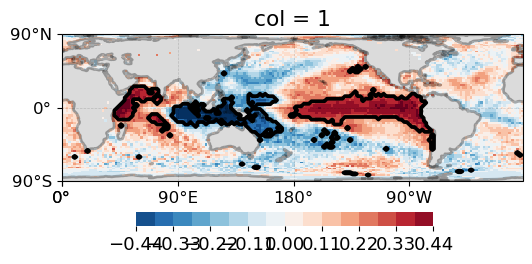

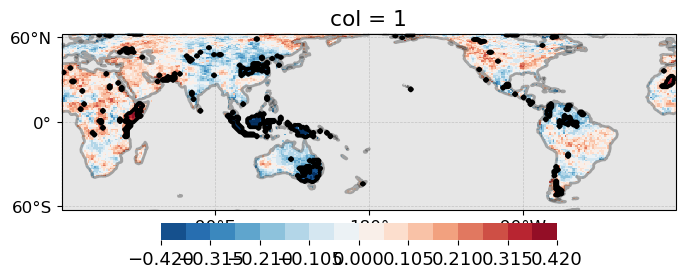

In [10]:
rg.plot_maps_corr()

In [11]:
rg.cluster_list_MI()

Plotting Corr maps sst_labels_init, split 0, lag 1
Plotting Corr maps sm_labels_init, split 0, lag 1


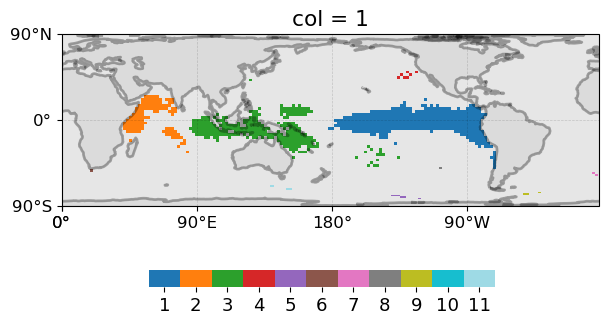

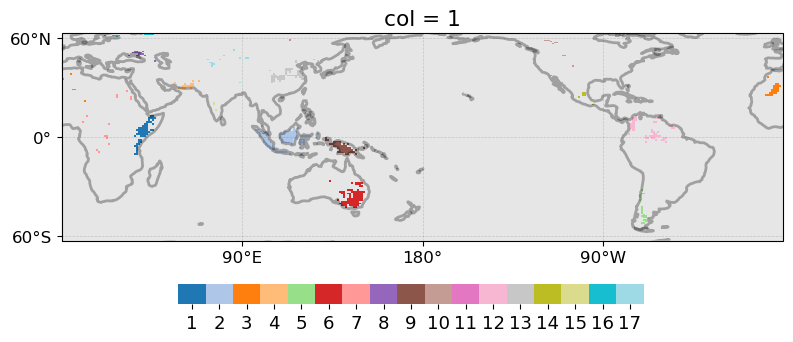

In [12]:
rg.quick_view_labels(mean=True) 

In [13]:
rg.get_ts_prec()


Getting MI timeseries
There are [28, 26, 27, 29] regions in total (list of different splits)


From the correlation (BivariateMI) map, the timeseries are named according the format:
{lag}..{region label}..{precursor name}, where precursor name is defined in list_of_name_path. 

In [14]:
rg.df_data

spatial_mean_raw  1..1..sst  1..2..sst  1..3..sst  1..4..sst  \
0 1981-01-16         -0.112610  -0.781289   0.026348  -0.154820   0.398731   
  1981-02-13          0.034485  -0.805915  -0.042760  -0.138640   0.388029   
  1981-03-13          1.793769  -0.455521   0.062720  -0.190565   0.256821   
  1981-04-10          3.000695  -0.359189  -0.090819  -0.097247  -0.001068   
  1981-05-08          0.295721  -0.184985   0.086693   0.043705   0.020359   
...                        ...        ...        ...        ...        ...   
3 2021-08-28         -0.100138  -0.329805   0.077558   0.469274   0.010437   
  2021-09-25         -0.040325  -0.477806  -0.212942   0.392571  -0.120627   
  2021-10-23         -1.570205  -0.698522  -0.157014   0.562189  -0.398112   
  2021-11-20         -0.787996  -0.851767  -0.052099   0.505736  -0.028306   
  2021-12-18          0.702164  -1.010576   0.108792   0.350579  -0.017447   

              1..5..sst  1..6..sst  1..7..sst  1..8..sst  1..9..sst  ...  \
0 1981-01-16   0.217529  -0.324348  -0.197452   0.262071   0.140344  ...   
  1981-02-13   0.218031  -0.454347  -0.198092   0.469227   0.005216  ...   
  1981-03-13   0.282002  -0.301338   0.080340   0.973964   0.072171  ...   
  1981-04-10   0.264594   0.154570  -0.291145   0.091206   0.165278  ...   
  1981-05-08   0.546930  -0.133687   0.027764   0.213893   0.207878  ...   
...                 ...        ...        ...        ...        ...  ...   
3 2021-08-28  -0.037178  -0.148478  -0.545841   0.213701   0.252842  ...   
  2021-09-25  -0.076690   0.619060  -0.503744   0.175116   0.236407  ...   
  2021-10-23  -0.166230   0.483450  -0.294653   0.214721   0.269690  ...   
  2021-11-20  -0.183940   0.084807  -0.186713   0.686340   0.186386  ...   
  2021-12-18  -0.189531  -0.609287   0.359545   0.470682  -0.014510  ...   

              1..11..sm  1..12..sm  1..13..sm  1..14..sm  1..15..sm  \
0 1981-01-16  -0.003781   0.003121  -0.004052   0.014834  -0.007629   
  1981-02-13  -0.003796   0.004421  -0.000167   0.022039  -0.003318   
  1981-03-13  -0.003774   0.014097  -0.003038   0.020645   0.002673   
  1981-04-10  -0.003621   0.004794   0.002448   0.012998   0.000357   
  1981-05-08  -0.003943   0.019840  -0.007951   0.015650   0.005124   
...                 ...        ...        ...        ...        ...   
3 2021-08-28   0.001678   0.014425   0.011366   0.016162   0.023066   
  2021-09-25   0.001539   0.012231   0.012873   0.016782   0.016157   
  2021-10-23   0.002605   0.013129   0.014992   0.013569   0.016715   
  2021-11-20   0.003583   0.014409   0.013229   0.007871   0.027499   
  2021-12-18   0.005370   0.021018   0.012074   0.006214   0.025611   

              1..16..sm  1..17..sm  1..10..sst  TrainIsTrue  RV_mask  
0 1981-01-16  -0.003539  -0.000697         NaN            0    False  
  1981-02-13  -0.003993   0.001884         NaN            0    False  
  1981-03-13  -0.003140   0.002115         NaN            0    False  
  1981-04-10  -0.002890   0.003447         NaN            0    False  
  1981-05-08   0.002005   0.003229         NaN            0    False  
...                 ...        ...         ...          ...      ...  
3 2021-08-28   0.000693   0.002550    0.029111            0    False  
  2021-09-25   0.000157  -0.000367   -0.245006            0    False  
  2021-10-23   0.000707   0.001890   -0.500611            0     True  
  2021-11-20   0.000664   0.001910   -0.330819            0     True  
  2021-12-18   0.000170   0.000893   -0.392211            0     True  

[2132 rows x 32 columns]

## Train-test cross-validation and Response Variable mask handling

- The different train-test folds are organized in the first level index.
- Each fold contains precursor timeseries that were extracted from only training data.
- The Training data is specified by the TrainIsTrue mask.
- The Response Variable mask defined the dates to predict 
- The RV_mask the anker for lag shifting the precursors.

The last two columns should be always present. 
- The RV_mask is defined by the start_end_TVdate.
- The TrainIsTrue is defined by the method for cross-validation.


In [18]:
from RGCPD.forecasting import func_models as fc_utils
def get_lag_shifted(df_data: pd.DataFrame, target_ts, lags_i: int, labels=None):
    if labels is None:
        labels = df_data.columns[1:-2]
    if type(lags_i) is int:
        lags_i = [lags_i]
    
    list_shifted_dfs = []
    for lag_i in lags_i:
        
        
        splits = df_data.index.levels[0]
        list_training_dfs = [] ; list_target = []
        for s in splits:
            fit_masks = fc_utils.apply_shift_lag(df_data.loc[s].iloc[:,-2:].copy(), lag_i=lag_i)
            x_fit = fit_masks['x_fit']

            # df_temp = df_data.loc[s][labels][x_fit]
            df_temp = df_data.loc[s][labels][x_fit]
            labels_new = [l+f'_{lag_i}' for l in labels]
            df_temp.columns = labels_new
            list_training_dfs.append(df_temp)
            # fix target
            y_fit = fit_masks['y_fit']
            
            list_target.append(target_ts.loc[s][y_fit])
            
        df_shifted = pd.concat(list_training_dfs, keys=splits)
        target_fit = pd.concat(list_target, keys=splits)

        df_shifted.index = target_fit.index
        df_shifted = pd.DataFrame(df_shifted.values, columns=df_shifted.columns, index=target_fit.index)
        list_shifted_dfs.append(df_shifted)
    df_data_shifted = pd.concat(list_shifted_dfs, axis=1)

    # restore train-test mask
    df_splits_adap = rg.df_splits.copy().loc[target_fit.index]
    df_splits_adap.index = df_data_shifted.index
    df_data_shifted = df_data_shifted.merge(df_splits_adap, left_index=True, right_index=True)

    return df_data_shifted, target_fit


# Forecasting pipeline

In [20]:
from RGCPD.forecasting import func_models as fc_utils
from RGCPD.forecasting.stat_models_cont import ScikitModel
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegressionCV

model = ScikitModel(LogisticRegressionCV, verbosity=0)
kwrgs_model = {'kfold':5,
               'scoring':'neg_brier_score'}

target_full_ts = target['tp_28d_rm'].loc[rg.df_fullts.index].to_dataframe()

quantiles = target['quantile'].to_dataframe()
quantiles = quantiles.loc[core_pp.get_oneyr(target_full_ts.index, rg.start_end_year[0]+1).day_of_year]

target_ts = target['binary'].sel(time=rg.df_fullts.index).to_dataframe()
target_ts = pd.concat([target_ts]*rg.n_spl, keys=range(rg.n_spl)) # make it align with train-test multi-index


BSS = fc_utils.ErrorSkillScore(constant_bench=0.33).BSS
score_func_list = [BSS, fc_utils.metrics.roc_auc_score]
    

        
# get df_data with shifted lags 
df_data_shifted, target_fit = get_lag_shifted(df_data=rg.df_data.copy(), target_ts=target_ts.copy(), 
                                              lags_i = [1,2], labels=None)

keys = [k for k in df_data_shifted.columns[:-2] if 'sst' in k]

out = rg.fit_df_data_ridge(target=target_fit,
                           keys=keys,
                           df_data=df_data_shifted,
                           fcmodel=model,
                           kwrgs_model=kwrgs_model,
                           transformer=fc_utils.standardize_on_train,
                           tau_min=0, tau_max=0)
predict, weights, model_lags = out

predict.index = df_data_shifted.iloc[:,-2:].index
df_train_m, df_test_s_m, df_test_m, df_boot = fc_utils.get_scores(predict,
                                                                 df_data_shifted.iloc[:,-2:],
                                                                 score_func_list,
                                                                 n_boot = 100,
                                                                 score_per_test=False,
                                                                 blocksize=1,
                                                                 rng_seed=1)
lag = 0

print(model.scikitmodel.__name__, '\n', f'Test score at lag {lag}\n',
      'BSS {:.2f}\n'.format(df_test_m.loc[0].loc[lag].loc['BSS']),
      'AUC {:.2f}'.format(df_test_m.loc[0].loc[lag].loc['roc_auc_score']),
      '\nTrain score\n',
      'BSS {:.2f}\n'.format(df_train_m.mean(0).loc[lag]['BSS']),
      'AUC {:.2f}'.format(df_train_m.mean(0).loc[lag]['roc_auc_score']))


LogisticRegressionCV 
 Test score at lag 0
 BSS -0.14
 AUC 0.58 
Train score
 BSS 0.18
 AUC 0.80


In [ ]:
ax = df_test_m.loc[0].plot.bar(rot=0, color=['blue', 'green', 'purple'], figsize=(10,4))
ax.set_xlabel('lag [in periods of 28-days]')
df_test_m

In [ ]:
from RGCPD.forecasting.stat_models import plot_importances
coeff, fig = plot_importances(models_splits_lags=model_lags, lag=1)
fig

## Causal Discovery using Tigramite

In [ ]:
# rg.PCMCI_df_data(tigr_function_call='run_pcmci',
#                  kwrgs_tigr={'tau_min': 1,
#                              'tau_max': 1,
#                              'pc_alpha': .2,
#                              'max_conds_dim': 2,
#                              'max_combinations': 1,
#                              'max_conds_py': 2,
#                              'max_conds_px': 0})

In [ ]:
# rg.PCMCI_get_links(var=rg.TV.name, alpha_level=.2, FDR_cv=False)
# rg.df_links

In [ ]:
# # on the left you see all the extraction precursor regions, on the right you see the regions which were found Conditionally Dependent (~Causal)
# rg.plot_maps_sum()